In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

###############################################################
# TERMINAL FILE PATH
# /opt/lumerical/v221/bin/fdtd-engine-mpich2nem /home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/MMIHybrid.fsp -t 8
# /opt/lumerical/v221/bin/fdtd-engine-mpich2nem /home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/MMIHybrid_s-parametersweep/s-parametersweep_1.fsp -t 8



In [94]:
hyb = lumapi.FDTD(filename='MMIHybrid.fsp',hide=False) 

## Functions

In [95]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly Parameters

In [96]:
# Topology ------------------------------------
InnerBd = 2* 1.6e-6  # Inner body X span (Sum of both parts)
OuterBd = 2* 2.4e-6  # Outer body X span (Sum of both parts)

CentWid = 1.48e-6  # Central Width
InnerWid = 1.48e-6  # Inner Width
OuterWid = 1.6e-6  # Outer Width

TLen = 1e-6  # Tapper length


# Simulation ----------------------------------
FDTDAccuracy = 4  # FDTD mesh accuracy

MeshEnable = 1  # Enable/Disable mesh
MSBd = {"dx":10e-9, "dy":4e-9, "dz":50e-9}  # Mesh maximum steps Body
MSPt = {"dx":10e-9, "dy":7e-9, "dz":50e-9}  # Mesh maximum steps Ports

## Assembly

In [97]:
hyb.switchtolayout()
hyb.deleteall()

# Creating the Full Body
Verts = np.array([[0,CentWid/2], [InnerBd/2,InnerWid/2], [(InnerBd+OuterBd)/2,OuterWid/2],
         [(InnerBd+OuterBd)/2,-OuterWid/2], [InnerBd/2,-InnerWid/2], [0,-CentWid/2],
         [-InnerBd/2,-InnerWid/2], [-(InnerBd+OuterBd)/2,-OuterWid/2],
         [-(InnerBd+OuterBd)/2,OuterWid/2], [-InnerBd/2,InnerWid/2]])   # Vertices

hyb.addpoly()
hyb.set("name", "FullBody")
hyb.set("vertices",Verts)
hyb.set({"x":0, "y":0, "z":0, "z span":220e-9,
        "material":"Si (Silicon) - Palik"})


# Creating the substract
RectInsert(0, OuterBd+InnerBd+2*TLen+4e-6, 0, OuterWid*2, -1e-6-110e-9, 2e-6, "SiO2 (Glass) - Palik", hyb)
hyb.set("name","Substract")


# Creating the Tappers
GenPar = {"first axis":"z", "z":0,
         "len":TLen, "thickness":0.22e-6,
         "width_r":0.7e-6, "width_l":0.5e-6, 
         "angle_side":90}    # General parameter sets

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":0, "name":"Input Taper 1",
         "x":-TLen/2-(InnerBd+OuterBd)/2, "y":OuterWid/2 - 0.35e-6})

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":0, "name":"Input Taper 2",
         "x":-TLen/2-(InnerBd+OuterBd)/2, "y":-OuterWid/2 + 0.35e-6})

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":180, "name":"Output Taper 1",
         "x":TLen/2+(InnerBd+OuterBd)/2, "y":OuterWid/2 - 0.35e-6})

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":180, "name":"Output Taper 2",
         "x":TLen/2+(InnerBd+OuterBd)/2, "y":-OuterWid/2 + 0.35e-6})


# Creating the post-tapper waveguides
RectInsert(-6e-6, 2e-6, 0.45e-6, 0.5e-6, 0, 220e-9, "Si (Silicon) - Palik",hyb)
hyb.set("name", "Input waveguide 1")
RectInsert(-6e-6, 2e-6, -0.45e-6, 0.5e-6, 0, 220e-9, "Si (Silicon) - Palik",hyb)
hyb.set("name", "Input waveguide 2")
RectInsert(6e-6, 2e-6, 0.45e-6, 0.5e-6, 0, 220e-9, "Si (Silicon) - Palik",hyb)
hyb.set("name", "Output waveguide 1")
RectInsert(6e-6, 2e-6, -0.45e-6, 0.5e-6, 0, 220e-9, "Si (Silicon) - Palik",hyb)
hyb.set("name", "Output waveguide 2")


# Creating FDTD region
hyb.addfdtd()
hyb.set({"x":0, "y":0, "z":0,
         "x span":OuterBd+InnerBd+2*TLen+1e-6, "y span": OuterWid*1.65, "z span":400e-9,
         "simulation time":1000e-15, "mesh accuracy":FDTDAccuracy})


# Creating monitor region
hyb.addpower()  # Planar monitor
hyb.set({"x":0, "x span":OuterBd+InnerBd+2*TLen, "y":0, "y span":OuterWid*1.65})
hyb.setglobalmonitor("use source limits",0)
hyb.setglobalmonitor("minimum wavelength",1500e-9)
hyb.setglobalmonitor("maximum wavelength",1600e-9)
hyb.setglobalmonitor("frequency points",20)


# Creating mesh region
if(MeshEnable == 1):
        hyb.addmesh()
        hyb.set({"x":0, "y":0, "z":0,
                "x span":OuterBd+InnerBd, "y span":OuterWid, "z span":220e-9,
                "name":"BodyMesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSBd["dx"],"dy":MSBd["dy"],"dz":MSBd["dz"]})

        hyb.addmesh()
        hyb.set({"x":-TLen/2-(InnerBd+OuterBd)/2, "y":0.45e-6, "z":0,
                "x span":TLen, "y span":0.7e-6, "z span":220e-9,
                "name":"Port1 Mesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSPt["dx"],"dy":MSPt["dy"],"dz":MSPt["dz"]})

        hyb.addmesh()
        hyb.set({"x":TLen/2+(InnerBd+OuterBd)/2, "y":0.45e-6, "z":0,
                "x span":TLen, "y span":0.7e-6, "z span":220e-9,
                "name":"Port2 Mesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSPt["dx"],"dy":MSPt["dy"],"dz":MSPt["dz"]})

        hyb.addmesh()
        hyb.set({"x":TLen/2 +(InnerBd+OuterBd)/2, "y":-0.45e-6, "z":0,
                "x span":TLen, "y span":0.7e-6, "z span":220e-9,
                "name":"Port3 Mesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSPt["dx"],"dy":MSPt["dy"],"dz":MSPt["dz"]})


# Creating Ports
hyb.addport()
hyb.set({"x":-5.5e-6, "y":0.45e-6, "z":0,
         "y span":0.75e-6, "z span":0.7e-6,
         "direction":"Forward"})

hyb.addport()
hyb.set({"x":5.5e-6, "y":0.45e-6, "z":0,
         "y span":0.55e-6, "z span":0.7e-6,
         "direction":"Backward"})

hyb.addport()
hyb.set({"x":5.5e-6, "y":-0.45e-6, "z":0,
         "y span":0.55e-6, "z span":0.7e-6,
         "direction":"Backward"})


# Editing source settings
hyb.select('FDTD::ports')
hyb.set('monitor frequency points',1500)
hyb.setglobalsource("wavelength start", 1500e-9)
hyb.setglobalsource("wavelength stop", 1600e-9)

1.0

## Load Power field

In [84]:
fIndex = 9  # Frequency index

P = hyb.getresult("monitor","P")
PwrArray = np.array(P['P'])
print(P.keys())
print(np.shape(PwrArray))

Px = PwrArray[:,:,0,fIndex,0]
Py = PwrArray[:,:,0,fIndex,1]
Pz = PwrArray[:,:,0,fIndex,2]

PAbs = np.sqrt(np.multiply(Px,Px) + np.multiply(Py,Py) + np.multiply(Py,Py))
Ax = ([ float(P['x'][0]) , float(P['x'][-1]) ])
Ay = ([ float(P['y'][0]) , float(P['y'][-1]) ])

# Plotting the color graph
plt.figure(figsize=(10,6))
ax = plt.imshow(np.abs(np.transpose(PAbs)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Power distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))

LumApiError: "Can not find result 'P' in the result provider 'monitor'"

## Load Transmission

dict_keys(['lambda', 'f', 'T', 'Lumerical_dataset'])


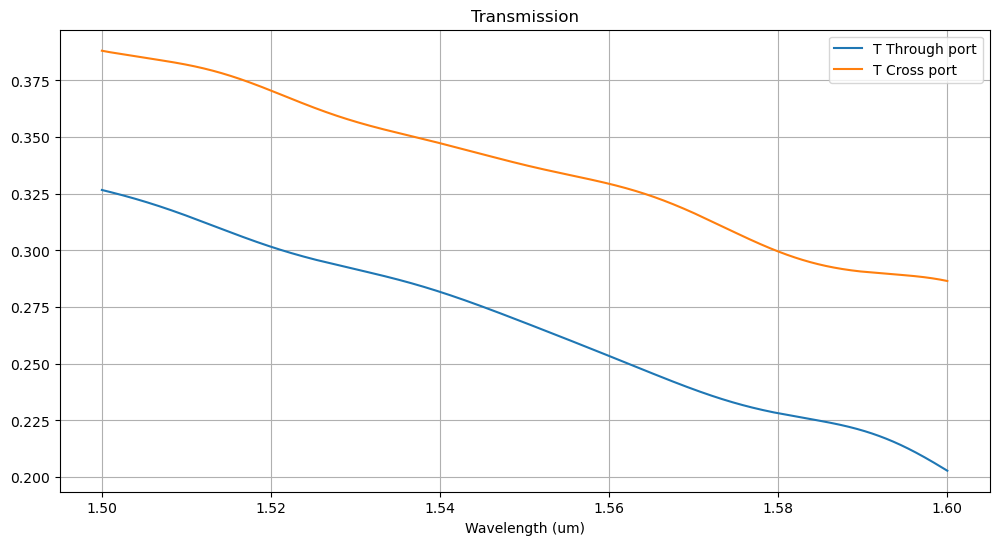

In [ ]:
T2 = hyb.getresult("FDTD::ports::port 2","T")
T3 = hyb.getresult("FDTD::ports::port 3","T")

print(T2.keys())
plt.figure(figsize=(12,6))
plt.plot(T2['lambda']*1e6, T2['T'], label='T Through port')
plt.plot(T3['lambda']*1e6, T3['T'], label='T Cross port')
plt.title('Transmission')
plt.xlabel('Wavelength (um)')
plt.grid(True)
plt.legend()

## Load S-parameters

dict_keys(['lambda', 'f', 'S11', 'S21', 'S31', 'Lumerical_dataset'])


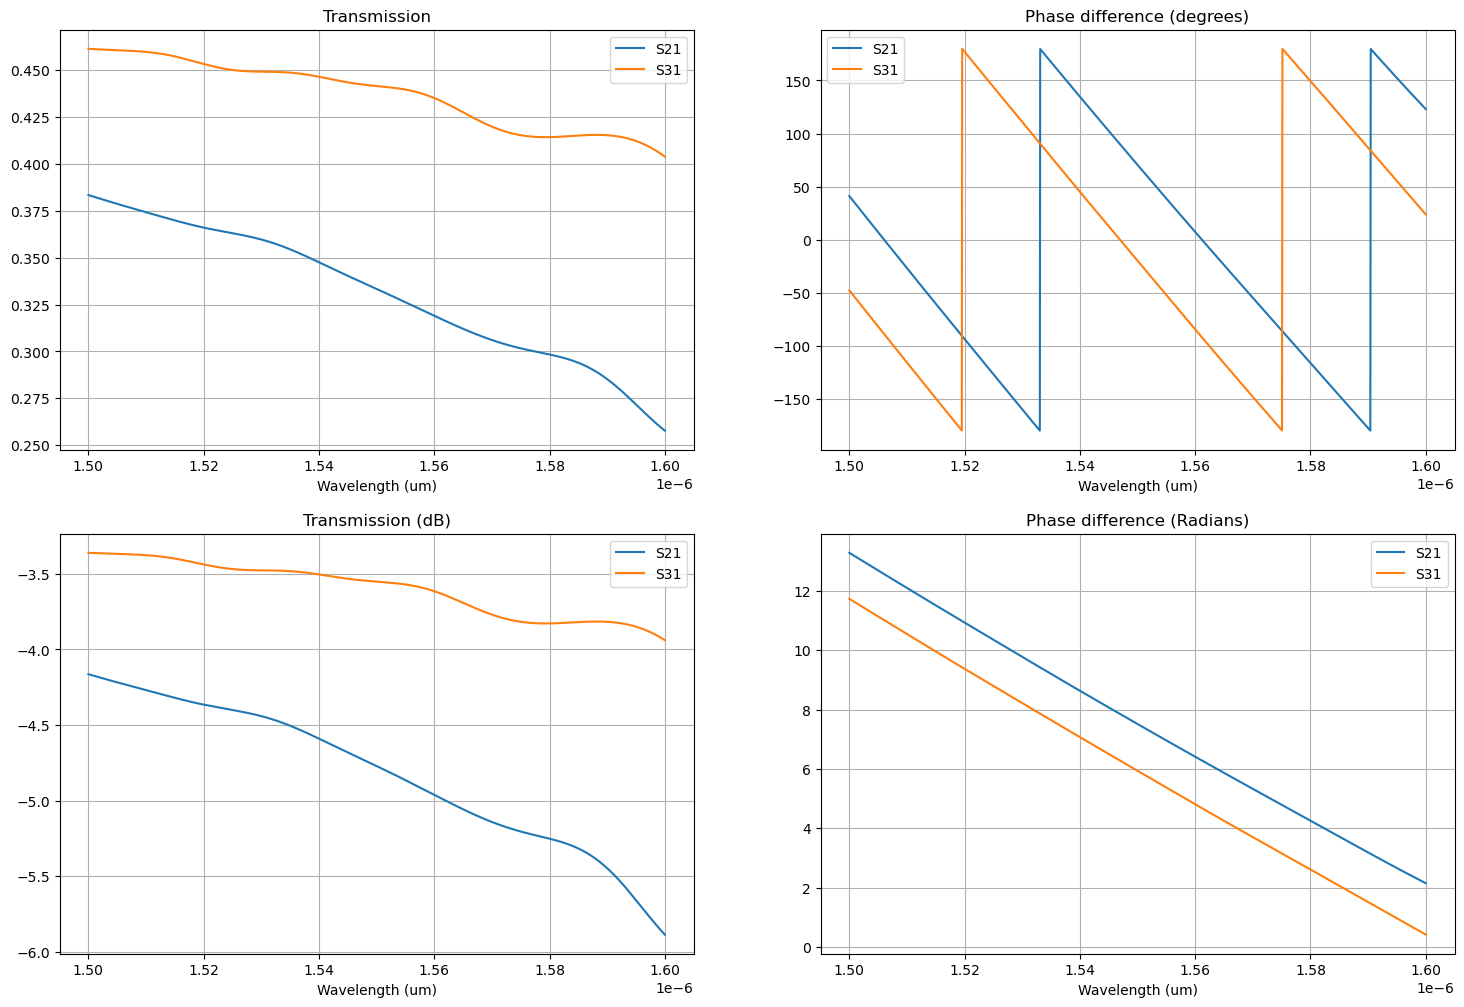

In [105]:
S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort2 = S['S21']
SPort3 = S['S31']
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0][0].plot(S['lambda'],np.abs(SPort2)**2, label='S21')
ax[0][0].plot(S['lambda'],np.abs(SPort3)**2, label='S31')
ax[0][0].set_title('Transmission')
ax[0][0].set_xlabel('Wavelength (um)')
ax[0][0].grid(True)
ax[0][0].legend()

ax[0][1].plot(S['lambda'],np.angle(SPort2, deg=True), label='S21')
ax[0][1].plot(S['lambda'],np.angle(SPort3, deg=True), label='S31')
ax[0][1].set_title('Phase difference (degrees)')
ax[0][1].set_xlabel('Wavelength (um)')
ax[0][1].grid(True)
ax[0][1].legend()

ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort2)**2), label='S21')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2), label='S31')
ax[1][0].set_title('Transmission (dB)')
ax[1][0].set_xlabel('Wavelength (um)')
ax[1][0].grid(True)
ax[1][0].legend()

ax[1][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort2)), label='S21')
ax[1][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort3)), label='S31')
ax[1][1].set_title('Phase difference (Radians)')
ax[1][1].set_xlabel('Wavelength (um)')
ax[1][1].grid(True)
ax[1][1].legend()